In [42]:
import sys
print(sys.version)
print(sys.executable)

3.10.19 (main, Oct  9 2025, 15:25:03) [Clang 17.0.0 (clang-1700.3.19.1)]
/Users/surbhitiwari/Desktop/MajorProject/hrv_env/bin/python


In [43]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.13.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [44]:
# ===============================
# Reproducibility & GPU setup
# ===============================

import os
import random
import numpy as np
import tensorflow as tf

SEED = 42

# Fix randomness (important for reliable results)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Prevent TensorFlow from grabbing all GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print("TensorFlow version:", tf.__version__)
print("GPUs detected:", gpus)


TensorFlow version: 2.13.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [45]:
# ===============================
# Core project imports
# ===============================

import wfdb
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    Dense,
    GlobalAveragePooling1D,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam

print("All core imports successful")


All core imports successful


In [46]:
# ===============================
# Dataset sanity check (FIXED)
# ===============================

import os

# Notebook is inside /notebooks, so go one level up
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_ROOT = os.path.join(PROJECT_ROOT, "data")

healthy_path = os.path.join(DATA_ROOT, "nsrdb")
chf_path = os.path.join(DATA_ROOT, "chfdb")

print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT)

print("\nHealthy folder exists:", os.path.exists(healthy_path))
print("CHF folder exists:", os.path.exists(chf_path))

print("\nHealthy records:")
print(os.listdir(healthy_path)[:5])

print("\nCHF records:")
print(os.listdir(chf_path)[:5])


Project root: /Users/surbhitiwari/Desktop/MajorProject
Data root: /Users/surbhitiwari/Desktop/MajorProject/data

Healthy folder exists: True
CHF folder exists: True

Healthy records:
['16272.atr', '17453.hea', '16795.dat', '19140.atr', '16273.atr']

CHF records:
['chf12.ecg', 'chf06.ecg', 'chf02.dat', 'chf03.dat', 'chf07.ecg']


In [47]:
# ===============================
# Robust RR extraction (FIXED)
# ===============================

def extract_rr(record_path):
    import wfdb
    import numpy as np
    import os

    record = wfdb.rdrecord(record_path)
    fs = record.fs

    ann = None

    # Try different annotation types
    for ann_type in ["atr", "qrs", "ecg"]:
        try:
            ann = wfdb.rdann(record_path, ann_type)
            break
        except:
            continue

    if ann is None:
        raise FileNotFoundError(
            f"No valid annotation found for record: {record_path}"
        )

    r_peaks = ann.sample
    rr = np.diff(r_peaks) / fs * 1000.0  # ms
    return rr



In [48]:
# ===============================
# Load ONE record correctly
# ===============================

# List files and extract unique record names
files = os.listdir(healthy_path)

# Keep only base record names (remove extensions)
records = sorted(list(set(f.split('.')[0] for f in files)))

test_record = records[0]   # e.g., "16272"
record_path = os.path.join(healthy_path, test_record)

print("Testing record:", test_record)
print("Full path:", record_path)

rr = extract_rr(record_path)

print("Number of RR intervals:", len(rr))
print("First 10 RR intervals (ms):")
print(rr[:10])



Testing record: 16265
Full path: /Users/surbhitiwari/Desktop/MajorProject/data/nsrdb/16265
Number of RR intervals: 100954
First 10 RR intervals (ms):
[398.4375 601.5625 609.375  601.5625 625.     609.375  625.     593.75
 601.5625 617.1875]


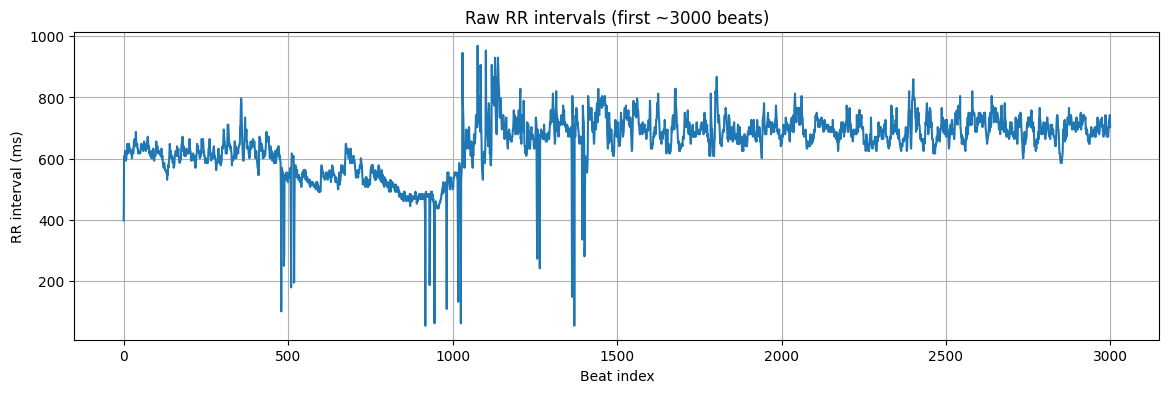

In [49]:
# ===============================
# Step 6: Visualize raw RR intervals
# ===============================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(rr[:3000], color="tab:blue")
plt.xlabel("Beat index")
plt.ylabel("RR interval (ms)")
plt.title("Raw RR intervals (first ~3000 beats)")
plt.grid(True)
plt.show()


In [50]:
# ===============================
# Step 7: Clean RR intervals
# ===============================

from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import numpy as np

def clean_rr(rr):
    # Physiological bounds (ms)
    rr = rr[(rr > 300) & (rr < 1600)]

    # Remove sudden unrealistic jumps
    clean = [rr[0]]
    for i in range(1, len(rr)):
        if abs(rr[i] - clean[-1]) / clean[-1] < 0.2:
            clean.append(rr[i])

    rr = np.array(clean)

    # Smooth while preserving trends
    rr = savgol_filter(rr, window_length=11, polyorder=2)

    # Interpolate to maintain continuity
    x = np.arange(len(rr))
    f = interp1d(x, rr, kind='linear', fill_value="extrapolate")
    return f(x)


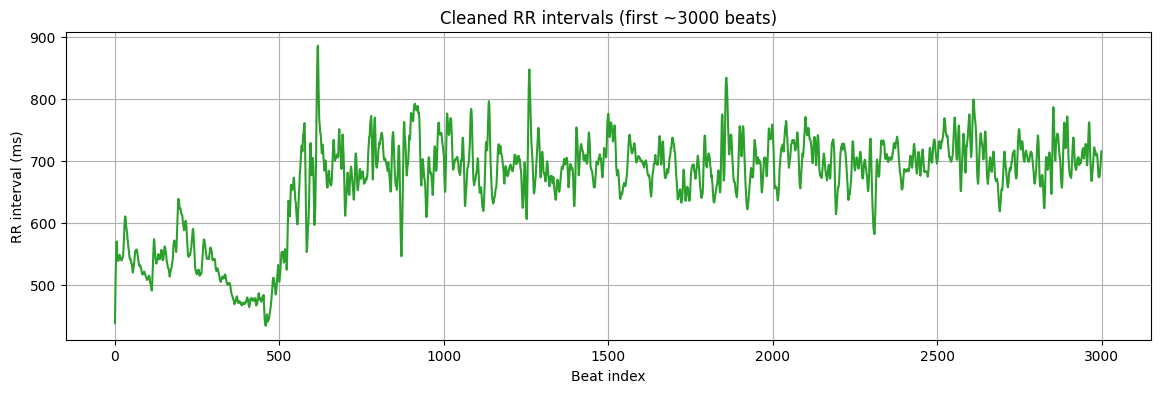

RR range after cleaning:
Min RR: 310.3875291375306 ms
Max RR: 1318.983100233106 ms


In [51]:
# ===============================
# Step 8: Visualize cleaned RR
# ===============================

rr_clean = clean_rr(rr)

plt.figure(figsize=(14, 4))
plt.plot(rr_clean[:3000], color="tab:green")
plt.xlabel("Beat index")
plt.ylabel("RR interval (ms)")
plt.title("Cleaned RR intervals (first ~3000 beats)")
plt.grid(True)
plt.show()

print("RR range after cleaning:")
print("Min RR:", rr_clean.min(), "ms")
print("Max RR:", rr_clean.max(), "ms")


In [52]:
# ===============================
# Step 9: Segment RR into long windows
# ===============================

def segment_rr(rr, window=7200, overlap=0.75):
    step = int(window * (1 - overlap))
    segments = []

    for start in range(0, len(rr) - window, step):
        segments.append(rr[start:start + window])

    return segments


segments = segment_rr(rr_clean)

print("Number of segments:", len(segments))
print("Length of one segment:", len(segments[0]))


Number of segments: 47
Length of one segment: 7200


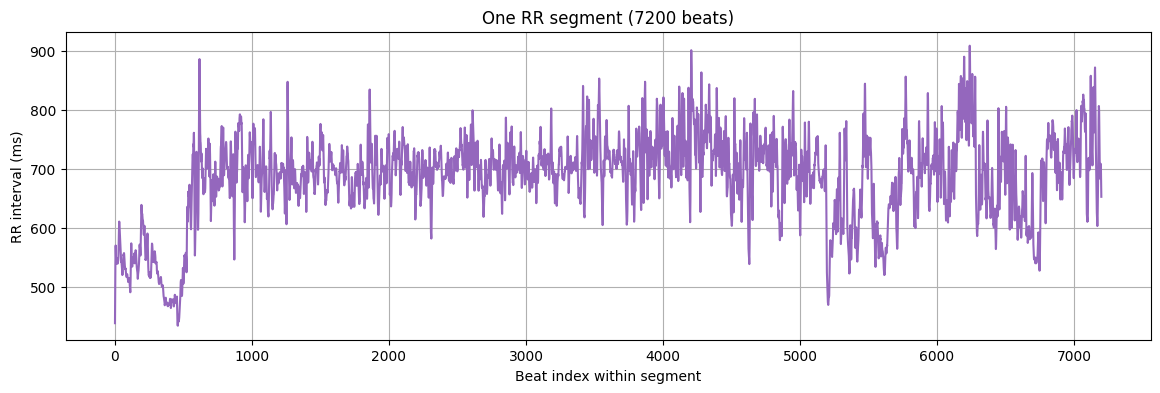

In [53]:
# ===============================
# Step 10: Visualize one RR segment
# ===============================

plt.figure(figsize=(14, 4))
plt.plot(segments[0], color="tab:purple")
plt.xlabel("Beat index within segment")
plt.ylabel("RR interval (ms)")
plt.title("One RR segment (7200 beats)")
plt.grid(True)
plt.show()


In [54]:
# ===============================
# Step 11: Define DMA scales
# ===============================

import numpy as np

# Scales chosen to cover short → long physiological dynamics
scales = np.linspace(5, 2000, 200).astype(int)

print("Number of scales:", len(scales))
print("Scale range:", scales[0], "to", scales[-1])


Number of scales: 200
Scale range: 5 to 2000


In [55]:
# ===============================
# Step 12: DMA computation
# ===============================

def compute_dma(rr, scales):
    rr = rr - np.mean(rr)  # remove DC offset
    F = np.zeros(len(scales))

    for i, s in enumerate(scales):
        ma = np.convolve(rr, np.ones(s)/s, mode='valid')
        detrended = rr[:len(ma)] - ma
        F[i] = np.sqrt(np.mean(detrended**2))

    return F


In [56]:
# ===============================
# Step 13: DMA for one RR segment
# ===============================

dma_curve = compute_dma(segments[0], scales)

print("DMA curve shape:", dma_curve.shape)
print("First 10 DMA values:", dma_curve[:10])


DMA curve shape: (200,)
First 10 DMA values: [20.33393376 36.61832272 40.92204003 43.2181346  44.90480595 45.9904613
 47.11426914 48.06253897 49.09645795 50.07663703]


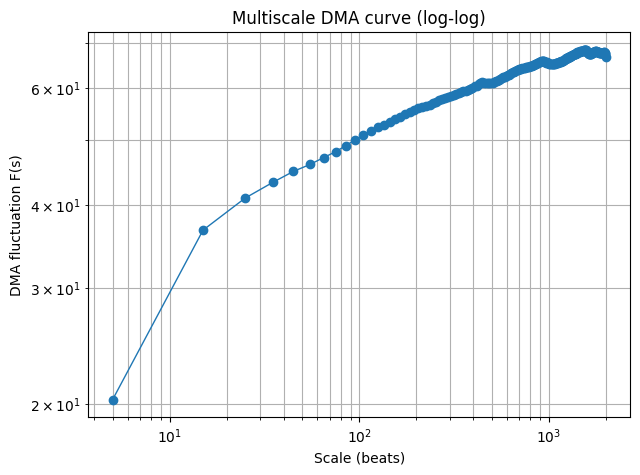

In [57]:
# ===============================
# Step 14: Plot DMA curve
# ===============================

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.loglog(scales, dma_curve, marker='o', linewidth=1)
plt.xlabel("Scale (beats)")
plt.ylabel("DMA fluctuation F(s)")
plt.title("Multiscale DMA curve (log-log)")
plt.grid(True, which="both")
plt.show()


In [58]:
# ===============================
# FIXED multi-channel DMA
# ===============================

def multi_channel_dma(rr):
    dma = compute_dma(rr, scales)

    # Enforce equal lengths
    band_len = 60

    short = dma[:band_len]                 # 0–60
    mid   = dma[70:70+band_len]            # 70–130
    long  = dma[140:140+band_len]           # 140–200 (trimmed)

    return np.stack([short, mid, long], axis=-1)


In [59]:
mc_dma = multi_channel_dma(segments[0])
print("Multi-channel DMA shape:", mc_dma.shape)



Multi-channel DMA shape: (60, 3)


In [60]:
# ===============================
# Step 18: Subject-level data loader
# ===============================

def load_subject(record_path, label):
    """
    Loads ONE subject and returns:
    - X: array of shape (num_segments, 60, 3)
    - y: subject label (0 = healthy, 1 = CHF)
    """

    rr = extract_rr(record_path)
    rr = clean_rr(rr)
    segments = segment_rr(rr)

    X = []
    for seg in segments:
        mc_dma = multi_channel_dma(seg)
        X.append(mc_dma)

    X = np.array(X)
    return X, label


In [61]:
# ===============================
# Step 19 (FIXED): Load entire dataset
# ===============================

subjects = []

# -------- Healthy subjects --------
healthy_files = os.listdir(healthy_path)

healthy_records = sorted(
    list(set(f.split('.')[0] for f in healthy_files))
)

print("Healthy records:", healthy_records)

for rec in healthy_records:
    record_path = os.path.join(healthy_path, rec)
    X, y = load_subject(record_path, label=0)
    subjects.append((X, y))


# -------- CHF subjects --------
chf_files = os.listdir(chf_path)

chf_records = sorted(
    list(set(f.split('.')[0] for f in chf_files))
)

print("CHF records:", chf_records)

for rec in chf_records:
    record_path = os.path.join(chf_path, rec)
    X, y = load_subject(record_path, label=1)
    subjects.append((X, y))


print("Total subjects loaded:", len(subjects))



Healthy records: ['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']
CHF records: ['chf01', 'chf02', 'chf03', 'chf04', 'chf05', 'chf06', 'chf07', 'chf08', 'chf09', 'chf10', 'chf11', 'chf12', 'chf13', 'chf14', 'chf15']
Total subjects loaded: 33


In [63]:
# ===============================
# Step 20: Sanity check subject data
# ===============================

X0, y0 = subjects[0]

print("Label:", y0)
print("Segments for subject:", X0.shape)
print("One segment shape:", X0[0].shape)



Label: 0
Segments for subject: (47, 60, 3)
One segment shape: (60, 3)


In [64]:
# ===============================
# Step 21: Subject-wise train/test split
# ===============================

labels = [y for (_, y) in subjects]

train_subjects, test_subjects = train_test_split(
    subjects,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print("Train subjects:", len(train_subjects))
print("Test subjects:", len(test_subjects))


Train subjects: 26
Test subjects: 7


In [65]:
# ===============================
# Step 22: Flatten segments for training
# ===============================

def flatten_subjects(subjects):
    X, y = [], []

    for X_subj, label in subjects:
        for seg in X_subj:
            X.append(seg)
            y.append(label)

    return np.array(X), np.array(y)


X_train, y_train = flatten_subjects(train_subjects)
X_test, y_test = flatten_subjects(test_subjects)

print("Training samples:", X_train.shape)
print("Test samples:", X_test.shape)


Training samples: (978, 60, 3)
Test samples: (210, 60, 3)


In [66]:
# ===============================
# Step 23: Feature normalization
# ===============================

mean = X_train.mean(axis=(0, 1), keepdims=True)
std  = X_train.std(axis=(0, 1), keepdims=True) + 1e-8

X_train = (X_train - mean) / std
X_test  = (X_test - mean) / std

print("Normalization applied.")


Normalization applied.


In [67]:
# ===============================
# Step 24: Class weights
# ===============================

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.9939024390243902, 1: 1.0061728395061729}


In [68]:
# ===============================
# Step 25: CNN model
# ===============================

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    Dense,
    GlobalAveragePooling1D,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam

def build_model():
    inputs = Input(shape=(60, 3))

    x = Conv1D(32, kernel_size=5, padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)

    x = Conv1D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = Conv1D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(64, activation="relu")(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, output)
    return model


model = build_model()
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


2026-01-04 13:26:41.781392: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-04 13:26:41.788896: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-01-04 13:26:41.793756: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-01-04 13:26:41.797545: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-04 13:26:41.799544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 3)]           0         
                                                                 
 conv1d (Conv1D)             (None, 60, 32)            512       
                                                                 
 batch_normalization (Batch  (None, 60, 32)            128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 64)            6208      
                                                                 
 batch_normalization_1 (Bat  (None, 60, 64)            256       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 128)           24704 

In [69]:
# ===============================
# Step 26: Train CNN
# ===============================

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/30


2026-01-04 13:28:27.836435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8376

2026-01-04 13:28:35.316223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 9s 110ms/step - loss: 0.3714 - accuracy: 0.8376 - val_loss: 0.5997 - val_accuracy: 0.8418
Epoch 2/30
25/25 [==============================] - 1s 20ms/step - loss: 0.3226 - accuracy: 0.8772 - val_loss: 0.6365 - val_accuracy: 0.7806
Epoch 3/30
25/25 [==============================] - 1s 26ms/step - loss: 0.3008 - accuracy: 0.8747 - val_loss: 0.6827 - val_accuracy: 0.5969
Epoch 4/30
25/25 [==============================] - 0s 16ms/step - loss: 0.2967 - accuracy: 0.8760 - val_loss: 0.6902 - val_accuracy: 0.6071
Epoch 5/30
25/25 [==============================] - 0s 16ms/step - loss: 0.2828 - accuracy: 0.8887 - val_loss: 0.6096 - val_accuracy: 0.7704
Epoch 6/30
25/25 [==============================] - 0s 15ms/step - loss: 0.2749 - accuracy: 0.8862 - val_loss: 0.7406 - val_accuracy: 0.5612
Epoch 7/30
25/25 [==============================] - 0s 13ms/step - loss: 0.2771 - accuracy: 0.8900 - val_loss: 0.7170 - val_accuracy: 0.5867
Epoch 8/30
25/25 [=====

In [70]:
# ===============================
# Step 27: Test evaluation
# ===============================

from sklearn.metrics import roc_auc_score, confusion_matrix

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("ROC AUC:", auc)
print("Confusion Matrix:\n", cm)


2026-01-04 13:29:30.004302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 65ms/step
ROC AUC: 0.899303008070433
Confusion Matrix:
 [[83 11]
 [34 82]]


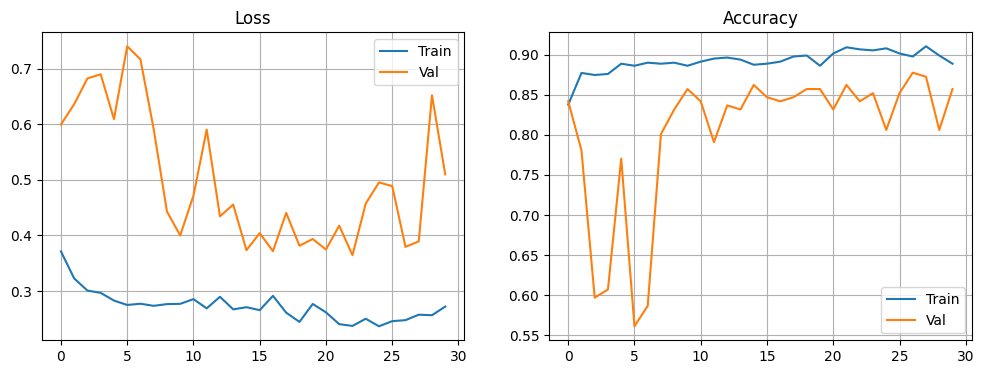

In [71]:
# ===============================
# Step 28: Training curves
# ===============================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.show()
